In [1]:
import torch
import numpy as np 
import os
import pandas as pd
import pickle
from datasets import MeltomeUnirepDataset
import models
from torch.utils.data import DataLoader
import time
import datetime
import torch.optim as optim
import torch.nn as nn
import random

In [2]:
# Housekeeping
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [3]:
# set unirep vector directory, and the path to the dictionary that contains the labels
URdir = "../datasets/Meltome_Vecs"
dict_path = "../datasets/protID2MT.p"
# creating a indexed dataset, returns a {"vec": tensor, "meltingTemp": num} for dataset[i]
MUData = MeltomeUnirepDataset(URdir=URdir, dictPath=dict_path, data="train")
MUVal = MeltomeUnirepDataset(URdir=URdir, dictPath=dict_path, data="val")
# creating a dataloader
train_loader = DataLoader(MUData, batch_size = 10, shuffle=True, num_workers=1)
val_loader = DataLoader(MUVal, batch_size = 10, num_workers=1)

In [4]:
# determining if able to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# creating a classifier
model = models.SimpleNN(h_units=2048)
model.to(device)

SimpleNN(
  (fc1): Linear(in_features=5700, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1, bias=True)
)

In [6]:
# training the classifier

def train_model(model, loader, epochs=1, loss_fn=None, optimizer=None):
    # define default loss functions and optimizer
    if not loss_fn:
        loss_fn = nn.MSELoss()
    if not optimizer:
        optimizer = optim.Adam(model.parameters(), lr=0.0003)
    
    model.train()
    
    loss_values = []

    for epoch in range(epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')
        t0 = time.time()
        running_loss = 0.0
        for i, data in enumerate(loader):
            inputs, label = data["vec"].to(device), data["meltingTemp"].to(device)

            optimizer.zero_grad()

            output = torch.flatten(model(inputs))
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            # keeping track of a running loss
            running_loss += loss.item()

            if i % label.shape[0] == 0 and not i == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i, len(loader), elapsed))
            
        #calculating the average training loss
        avg_train_loss = running_loss / len(loader)
        loss_values.append(avg_train_loss)
        #printing updates
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    return loss_values

def eval_model(model, loader, loss_fn=None):

    if not loss_fn:
        loss_fn = nn.MSELoss()

    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in loader:
        inputs, labels = batch["vec"].to(device), batch["meltingTemp"].to(device)

        with torch.no_grad():
            #forward pass without gradient calculations for speeeeeed

            outputs = torch.flatten(model(inputs))

        # calculating validation loss
        tmp_eval_accuracy = loss_fn(outputs, labels)

        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1

    print("  Loss: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    return float(eval_accuracy/nb_eval_steps)

In [7]:
train_loss = []
val_loss = []
for i in range(40): 
    train_loss.extend(train_model(model, train_loader, epochs=1))
    val_loss.append(eval_model(model, val_loader))

d: 0:00:15.
  Batch   900  of  2,546.    Elapsed: 0:00:15.
  Batch   910  of  2,546.    Elapsed: 0:00:15.
  Batch   920  of  2,546.    Elapsed: 0:00:16.
  Batch   930  of  2,546.    Elapsed: 0:00:16.
  Batch   940  of  2,546.    Elapsed: 0:00:16.
  Batch   950  of  2,546.    Elapsed: 0:00:16.
  Batch   960  of  2,546.    Elapsed: 0:00:16.
  Batch   970  of  2,546.    Elapsed: 0:00:16.
  Batch   980  of  2,546.    Elapsed: 0:00:17.
  Batch   990  of  2,546.    Elapsed: 0:00:17.
  Batch 1,000  of  2,546.    Elapsed: 0:00:17.
  Batch 1,010  of  2,546.    Elapsed: 0:00:17.
  Batch 1,020  of  2,546.    Elapsed: 0:00:17.
  Batch 1,030  of  2,546.    Elapsed: 0:00:17.
  Batch 1,040  of  2,546.    Elapsed: 0:00:18.
  Batch 1,050  of  2,546.    Elapsed: 0:00:18.
  Batch 1,060  of  2,546.    Elapsed: 0:00:18.
  Batch 1,070  of  2,546.    Elapsed: 0:00:18.
  Batch 1,080  of  2,546.    Elapsed: 0:00:18.
  Batch 1,090  of  2,546.    Elapsed: 0:00:18.
  Batch 1,100  of  2,546.    Elapsed: 0:00:19.
 

In [20]:
train_loss = [123.52837552129051, 99.58595671479569, 90.38171835162933, 86.84014869963008, 84.57514128231759, 82.66377059025551, 81.32322055677308, 79.65800923020092, 80.04305437691832, 77.70301629629832, 77.11512796464906, 76.43282894908398, 75.77462827794119, 75.86097852824854, 75.53659149163929, 74.64705326476626, 74.40628134651813, 74.02394978567455, 73.30134405700223, 73.44900711858169, 73.05960539449225, 73.15757004388747, 72.7875414001408, 73.02173244307009, 72.77748162205165, 71.97464782238382, 71.54591845323603, 71.4657276762768, 71.0726497244479, 71.62986749602601, 70.44402534289334, 71.4622128296348, 70.58914589095284, 69.87495398334134, 70.40164272876959, 70.57263298727167, 69.87488362570026, 69.57595518416339, 69.63331839425865, 69.96292149842675]

val_loss = [93.88915252685547, 98.1513900756836, 122.28421020507812, 75.50746154785156, 77.52014923095703, 85.73162078857422, 80.3565444946289, 148.76388549804688, 87.70313262939453, 82.0040512084961, 76.46597290039062, 79.37683868408203, 80.96031188964844, 87.51619720458984, 117.6851806640625, 76.51962280273438, 93.38921356201172, 74.6185531616211, 74.42374420166016, 74.22330474853516, 78.81029510498047, 79.4541244506836, 84.82635498046875, 70.83541870117188, 92.2903823852539, 85.32516479492188, 72.74823760986328, 89.92372131347656, 109.72217559814453, 76.74150848388672, 84.77648162841797, 72.9856185913086, 72.9090805053711, 72.8861312866211, 72.7496566772461, 84.82450103759766, 78.2412338256836, 75.61578369140625, 76.20689392089844, 80.35364532470703]

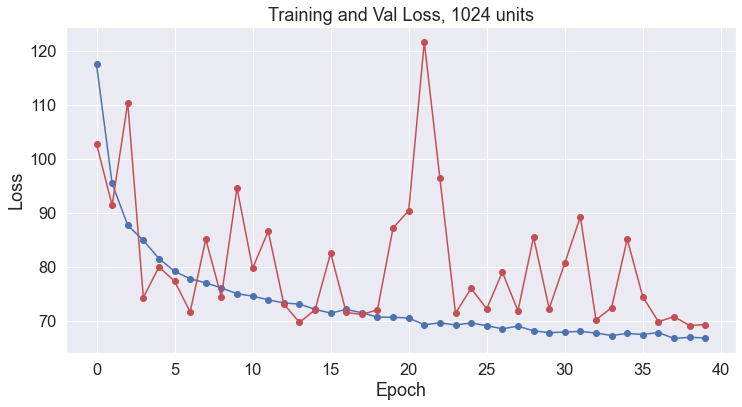

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def plot_loss_vals(loss_vals, lv2, title="Training loss"):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(loss_vals, 'b-o')
    plt.plot(lv2, 'r-o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
plot_loss_vals(train_loss, val_loss, title="Training and Val Loss, 1024 units")

In [9]:
with open("temp.txt", "a") as f:
    f.write("2048\n")
    f.write(str(train_loss) + "\n")
    f.write(str(val_loss) + "\n")